In [135]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
# Preprocessing Libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipelines
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


# Model Evaluation Libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate



In [136]:
# Load dataset
# Get Raw GitHub URL
DATA_URL = (
    "https://raw.githubusercontent.com/"
    "msselizabeth/smart-ml-retail-model/"
    "development/data/raw/retail_sales_dataset.csv"
)

# Alternative way to get the dataset
DATA_URL = "../data/raw/retail_sales_dataset.csv"

# Read data and inspect data types
retail_data = pd.read_csv(
    DATA_URL)

# Remove duplicates if any
retail_data = retail_data.drop_duplicates()

print(retail_data.shape)
print(retail_data.dtypes)

(1000, 9)
Transaction ID       int64
Date                object
Customer ID         object
Gender              object
Age                  int64
Product Category    object
Quantity             int64
Price per Unit       int64
Total Amount         int64
dtype: object


In [137]:
# Convert date column
retail_data['Date'] = pd.to_datetime(
    retail_data['Date'], 
    errors='raise'
)
# Extract a month, day of a week, weekend from the data
# retail_data["Month"]  = retail_data["Date"].dt.month
# retail_data["DayOfWeek"]  = retail_data["Date"].dt.dayofweek
# retail_data["IsWeekend"]  = (retail_data["DayOfWeek"] >= 5).astype(int)

print("After: ", retail_data['Date'].dtype)  # datetime64[ns]

After:  datetime64[ns]


In [138]:
# Print data info
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    1000 non-null   int64         
 1   Date              1000 non-null   datetime64[ns]
 2   Customer ID       1000 non-null   object        
 3   Gender            1000 non-null   object        
 4   Age               1000 non-null   int64         
 5   Product Category  1000 non-null   object        
 6   Quantity          1000 non-null   int64         
 7   Price per Unit    1000 non-null   int64         
 8   Total Amount      1000 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 70.4+ KB


In [139]:
# Normalize date and set as index
retail_data['Date'] = retail_data['Date'].dt.normalize()

# Set the date as index for time-series analysis
retail_data.set_index('Date', inplace=True)

# Quick checks
print("Columns:", retail_data.columns)
print("Index name:", retail_data.index.name, "dtype:", retail_data.index.dtype)


Columns: Index(['Transaction ID', 'Customer ID', 'Gender', 'Age', 'Product Category',
       'Quantity', 'Price per Unit', 'Total Amount'],
      dtype='object')
Index name: Date dtype: datetime64[ns]


In [140]:
# Dates of January 2024 transactions:
jan24_retail_data = retail_data.loc['2024-01']

# To just see the unique dates that occur:
unique_dates = jan24_retail_data.index.date
print(unique_dates)

[datetime.date(2024, 1, 1) datetime.date(2024, 1, 1)]


In [141]:
# Remove all rows where the index month is Jan 2024 (because it;s only few of t24)
retail_data = retail_data[~(retail_data.index.to_period('M') == '2024-01')]

# Quick check
print("New date range:", retail_data.index.min().date(), "to", retail_data.index.max().date())

New date range: 2023-01-01 to 2023-12-31


In [142]:
## Clean Data
# Strip whitespace and rename all columns to snake_case
retail_data.columns = (
    retail_data.columns
      .str.strip()                             
      .str.lower()                             # lowercase all characters
      .str.replace(r'[^0-9a-z]+', '_', regex=True)  # non-alphanumerics → underscore
      .str.replace(r'__+', '_', regex=True)        # collapse repeated underscores
      .str.strip('_')                          # remove leading/trailing underscores
)

# Convert categorical columns to 'category' dtype
for col in retail_data.select_dtypes(include=['object']).columns:
    retail_data[col] = retail_data[col].astype('category')

In [143]:
# Inspect the first few rows of the dataset
print(retail_data.head())

            transaction_id customer_id  gender  age product_category  \
Date                                                                   
2023-11-24               1     CUST001    Male   34           Beauty   
2023-02-27               2     CUST002  Female   26         Clothing   
2023-01-13               3     CUST003    Male   50      Electronics   
2023-05-21               4     CUST004    Male   37         Clothing   
2023-05-06               5     CUST005    Male   30           Beauty   

            quantity  price_per_unit  total_amount  
Date                                                
2023-11-24         3              50           150  
2023-02-27         2             500          1000  
2023-01-13         1              30            30  
2023-05-21         1             500           500  
2023-05-06         2              50           100  


In [144]:
## Inspect shape, missing values, and duplicates and more
# 1. Shape
print(f"Shape of the dataset: {retail_data.shape}")

# 2. Missing values
print(f"Missing values in the dataset:\n{retail_data.isnull().sum()}")

# 3. Duplicates
print(f"Number of duplicate rows: {retail_data.duplicated().sum()}")

# 4. Negative or zero checks
print((retail_data['quantity'] <= 0).sum(), 'bad quantities')
print((retail_data['price_per_unit'] <= 0).sum(), 'bad prices')

# 5. Age range
min_age = retail_data['age'].min()
max_age = retail_data['age'].max()
print(f"Age range: {min_age} to {max_age}")

Shape of the dataset: (998, 8)
Missing values in the dataset:
transaction_id      0
customer_id         0
gender              0
age                 0
product_category    0
quantity            0
price_per_unit      0
total_amount        0
dtype: int64
Number of duplicate rows: 0
0 bad quantities
0 bad prices
Age range: 18 to 64


In [145]:
# Initial transaction count
# 6. Transaction count by gender
gender_counts = retail_data['gender'].value_counts()
print("Transaction counts by gender:")
print(gender_counts)

# 7. Transaction count by product category
category_counts = retail_data['product_category'].value_counts()
print("Transaction counts by product category:")
print(category_counts)

# 8. Transaction count by age group
age_counts = retail_data['age'].value_counts()
print("Transaction counts by age:")
print(age_counts)

Transaction counts by gender:
gender
Female    510
Male      488
Name: count, dtype: int64
Transaction counts by product category:
product_category
Clothing       351
Electronics    341
Beauty         306
Name: count, dtype: int64
Transaction counts by age:
age
43    31
64    31
57    30
51    30
34    28
54    28
22    27
62    27
47    26
46    25
42    25
23    24
40    24
50    23
27    23
52    22
60    22
30    22
26    22
31    22
35    22
28    21
41    21
18    21
20    21
19    21
21    20
25    20
55    20
49    19
56    19
32    19
38    19
61    18
39    18
48    18
63    17
45    17
59    17
53    17
29    16
37    16
36    15
44    15
24    15
58    14
33    10
Name: count, dtype: int64


In [146]:
# Checking if necessary to optimize transaction IDs and customer IDs
# Check for unique values in ID columns
n = len(retail_data)
print(f"Unique Transaction IDs: {retail_data['transaction_id'].nunique()} out of {n}")
print(f"Unique Customer IDs: {retail_data['customer_id'].nunique()} out of {n}")


Unique Transaction IDs: 998 out of 998
Unique Customer IDs: 998 out of 998


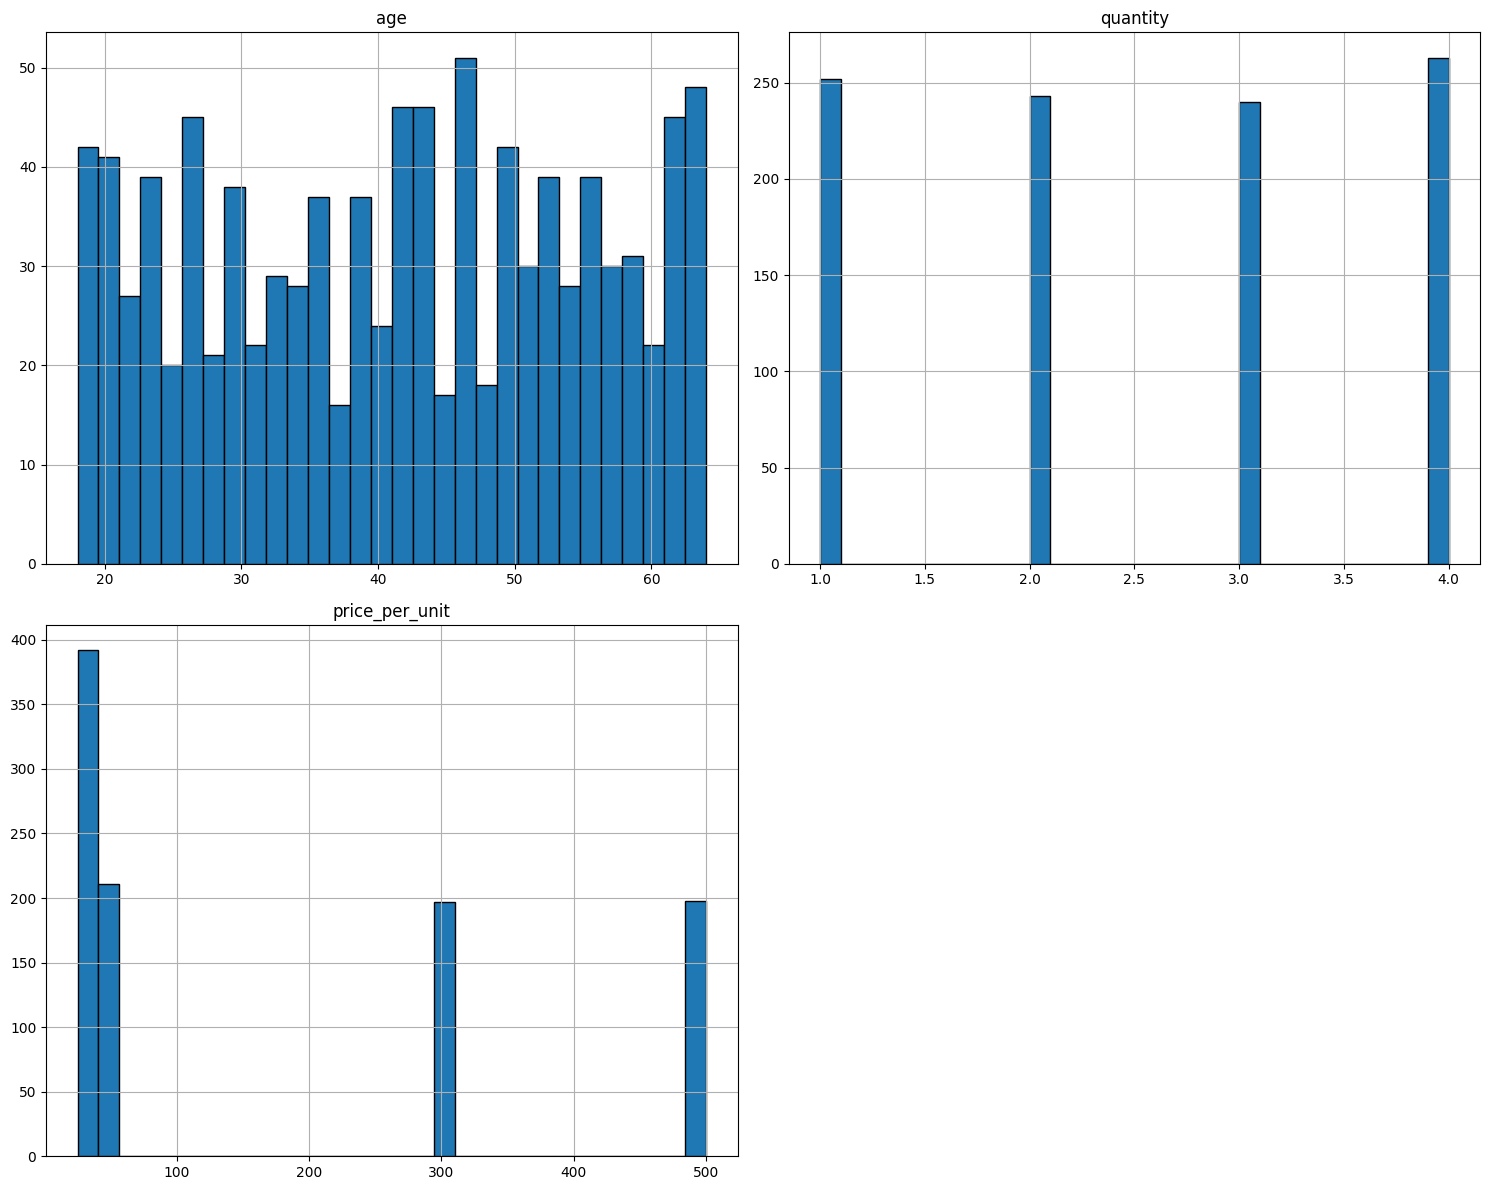

In [147]:
# Visualize the distribution of numeric features
numeric_cols = ['age', 'quantity', 'price_per_unit']

# Set up subplots
retail_data[numeric_cols].hist(bins=30, figsize=(15, 12), layout=(2, 2),edgecolor='k')
plt.tight_layout()
plt.show()

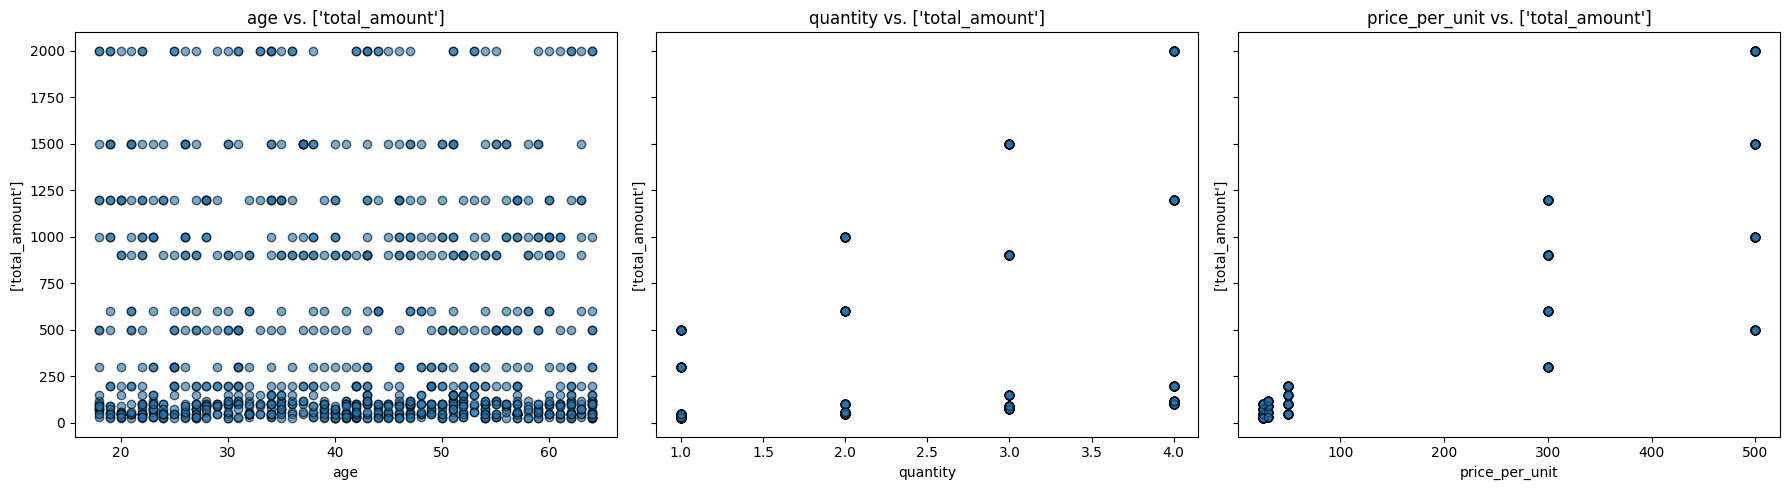

In [148]:
# Scatterplots
y_col=['total_amount']
# Create a row of 3 scatter plots
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(18, 5), sharey=True)

for ax, col in zip(axes, numeric_cols):
    ax.scatter(retail_data[col], retail_data[y_col], alpha=0.6, edgecolor='k')
    ax.set_xlabel(col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{col} vs. {y_col}')

plt.tight_layout()
plt.show()

In [149]:
#Quick checks        
print(retail_data.describe())   
print(retail_data['product_category'].value_counts())  
print(retail_data.groupby('product_category')['total_amount'].sum())

       transaction_id         age    quantity  price_per_unit  total_amount
count      998.000000  998.000000  998.000000      998.000000    998.000000
mean       500.640281   41.377756    2.515030      179.719439    455.380762
std        288.924735   13.688342    1.132751      189.541154    559.420064
min          1.000000   18.000000    1.000000       25.000000     25.000000
25%        251.250000   29.000000    1.000000       30.000000     60.000000
50%        500.500000   42.000000    3.000000       50.000000    135.000000
75%        750.750000   53.000000    4.000000      300.000000    900.000000
max       1000.000000   64.000000    4.000000      500.000000   2000.000000
product_category
Clothing       351
Electronics    341
Beauty         306
Name: count, dtype: int64
product_category
Beauty         142015
Clothing       155580
Electronics    156875
Name: total_amount, dtype: int64


/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/3687549348.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(retail_data.groupby('product_category')['total_amount'].sum())


In [150]:
# Check for outliers in 'Total Amount'
# Compute Q1, Q3, and IQR for Total Amount
Q1 = retail_data['total_amount'].quantile(0.25)
Q3 = retail_data['total_amount'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
lo_outliers = retail_data[retail_data['total_amount'] < lower_bound].shape[0]
hi_outliers = retail_data[retail_data['total_amount'] > upper_bound].shape[0]

print(f"IQR method → lower bound: {lower_bound}, upper bound: {upper_bound}")
print(f"Number of lower outliers: {lo_outliers}")
print(f"Number of upper outliers: {hi_outliers}")

IQR method → lower bound: -1200.0, upper bound: 2160.0
Number of lower outliers: 0
Number of upper outliers: 0


In [151]:
# Check outliers in Price per Unit
summary = []
for category, grp in retail_data.groupby('product_category'):
    Q1 = grp['price_per_unit'].quantile(0.25)
    Q3 = grp['price_per_unit'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_low = (grp['price_per_unit'] < lower).sum()
    n_high = (grp['price_per_unit'] > upper).sum()
    summary.append({
        'Category':       category,
        'Q1':             Q1,
        'Q3':             Q3,
        'IQR':            IQR,
        'Lower Bound':    lower,
        'Upper Bound':    upper,
        'Lower Outliers': n_low,
        'Upper Outliers': n_high
    })

outlier_retail_data= pd.DataFrame(summary).set_index('Category')
print(outlier_retail_data)

               Q1     Q3    IQR  Lower Bound  Upper Bound  Lower Outliers  \
Category                                                                    
Beauty       30.0  300.0  270.0       -375.0        705.0               0   
Clothing     30.0  300.0  270.0       -375.0        705.0               0   
Electronics  30.0  300.0  270.0       -375.0        705.0               0   

             Upper Outliers  
Category                     
Beauty                    0  
Clothing                  0  
Electronics               0  


/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/2649610634.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, grp in retail_data.groupby('product_category'):


In [152]:
# Check outliers in Quantity
summary = []

for category, grp in retail_data.groupby('product_category'):
    Q1 = grp['quantity'].quantile(0.25)
    Q3 = grp['quantity'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_low = (grp['quantity'] < lower).sum()
    n_high = (grp['quantity'] > upper).sum()
    summary.append({
        'Category':       category,
        'Q1':             Q1,
        'Q3':             Q3,
        'IQR':            IQR,
        'Lower Bound':    lower,
        'Upper Bound':    upper,
        'Lower Outliers': n_low,
        'Upper Outliers': n_high
    })

outlier_retail_data = pd.DataFrame(summary).set_index('Category')
print(outlier_retail_data)

              Q1   Q3  IQR  Lower Bound  Upper Bound  Lower Outliers  \
Category                                                               
Beauty       2.0  3.0  1.0         0.50         4.50               0   
Clothing     1.5  4.0  2.5        -2.25         7.75               0   
Electronics  1.0  4.0  3.0        -3.50         8.50               0   

             Upper Outliers  
Category                     
Beauty                    0  
Clothing                  0  
Electronics               0  


/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/1240766723.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, grp in retail_data.groupby('product_category'):


In [153]:
# Pricing trends
# Pivot: rows are product_category, columns are price_per_unit, values are transaction counts
price_counts_pivot = (
    retail_data
    .groupby(['product_category', 'price_per_unit'])
    .size()
    .unstack(fill_value=0)
)

# Display or inspect
print(price_counts_pivot)

price_per_unit    25   30   50   300  500
product_category                         
Beauty             63   56   67   53   67
Clothing           75   65   75   72   64
Electronics        72   61   69   72   67


/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/2676352520.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['product_category', 'price_per_unit'])


/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/3985103020.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['product_category', 'price_per_unit'])


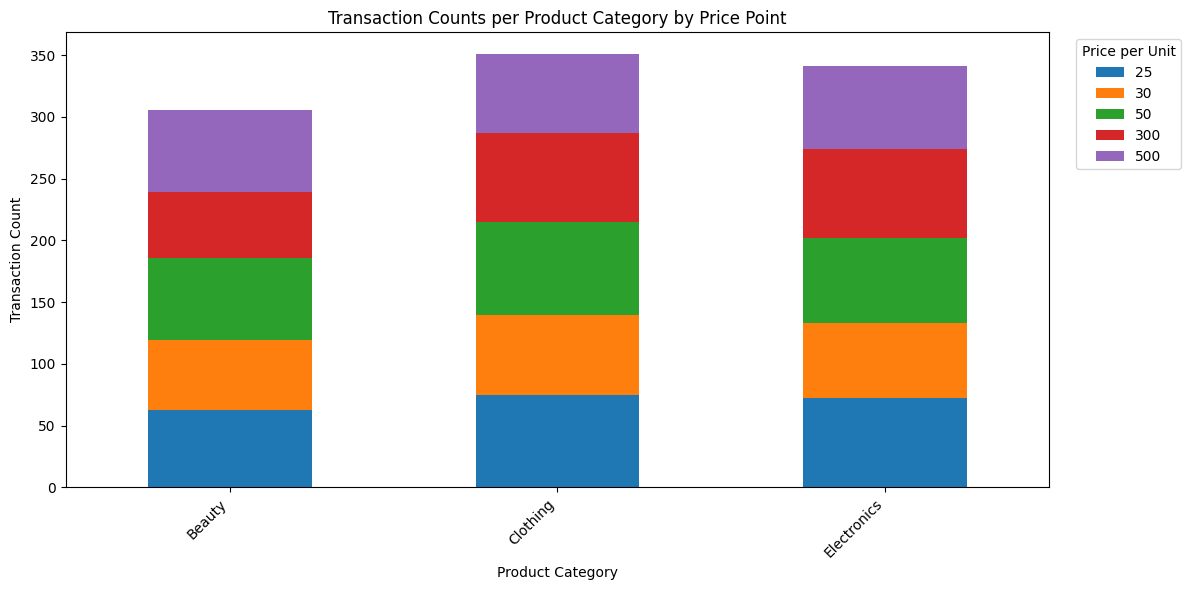

In [154]:
# Plot pricing trends
# Pivot: rows=categories, cols=price points, values=transaction counts
price_counts_pivot = (
    retail_data
    .groupby(['product_category', 'price_per_unit'])
    .size()
    .unstack(fill_value=0)
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
price_counts_pivot.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('Product Category')
ax.set_ylabel('Transaction Count')
ax.set_title('Transaction Counts per Product Category by Price Point')
plt.xticks(rotation=45, ha='right')
ax.legend(title='Price per Unit', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [155]:
# Split price points per gender
# 1) Pivot for Male transactions
male_pivot = (
    retail_data[retail_data['gender'] == 'Male']
      .groupby(['product_category', 'price_per_unit'])
      .size()
      .unstack(fill_value=0)
)

# 2) Pivot for Female transactions
female_pivot = (
    retail_data[retail_data['gender'] == 'Female']
      .groupby(['product_category', 'price_per_unit'])
      .size()
      .unstack(fill_value=0)
)

# 3) Display them (in a Jupyter notebook you can use display; otherwise just print)
from IPython.display import display

print("=== Male: Transaction Counts by Category & Price ===")
display(male_pivot)

print("\n=== Female: Transaction Counts by Category & Price ===")
display(female_pivot)

=== Male: Transaction Counts by Category & Price ===


/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/4019662511.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['product_category', 'price_per_unit'])
/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/4019662511.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['product_category', 'price_per_unit'])


price_per_unit,25,30,50,300,500
product_category,,,,,
Beauty,23,32,30,24,31
Clothing,38,28,46,33,32
Electronics,34,30,37,34,36



=== Female: Transaction Counts by Category & Price ===


price_per_unit,25,30,50,300,500
product_category,,,,,
Beauty,40,24,37,29,36
Clothing,37,37,29,39,32
Electronics,38,31,32,38,31


In [156]:
# Group by Generation
# Define the 2023 generation cut-points
gen_bins  = [18, 26, 42, 57, 77]               
gen_labels = ['Gen Z (18–26)', 
              'Millennials (27–42)', 
              'Gen X (43–57)', 
              'Baby Boomers (58–77)']

# Create a new Generation column
retail_data['generation'] = pd.cut(
    retail_data['age'],
    bins=gen_bins,
    labels=gen_labels,
    right=True,   
    include_lowest=True
)

# Now see the revenue by those cohorts
gen_rev = retail_data.groupby('generation')['total_amount'].sum()
print(gen_rev)

generation
Gen Z (18–26)            98530
Millennials (27–42)     143015
Gen X (43–57)           151245
Baby Boomers (58–77)     61680
Name: total_amount, dtype: int64


/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/3399377694.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gen_rev = retail_data.groupby('generation')['total_amount'].sum()


/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/1697221343.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['price_per_unit', 'generation'])


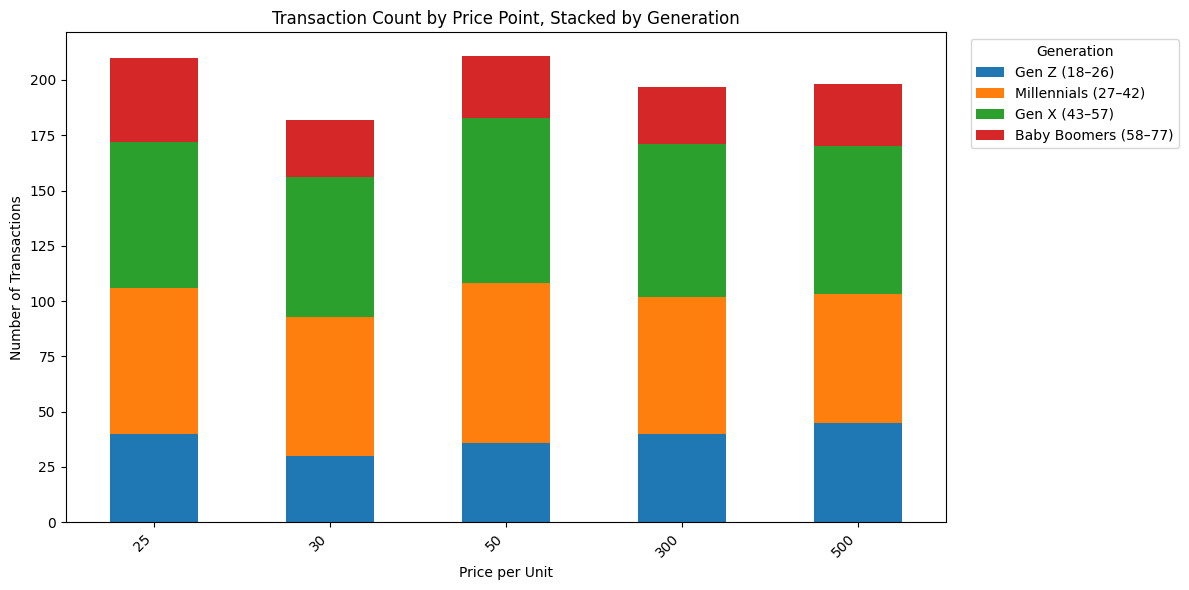

In [157]:
# Plot transaction counts by price point and generation
# 1) Pivot transaction counts by price point and generation
count_price_gen = (
    retail_data
      .groupby(['price_per_unit', 'generation'])
      .size()                     # count rows = transactions
      .unstack(fill_value=0)      # generations become columns
)

# 2) Plot as a stacked bar chart
fig, ax = plt.subplots(figsize=(12,6))
count_price_gen.plot(kind='bar', stacked=True, ax=ax)

# 3) Formatting
ax.set_xlabel('Price per Unit')
ax.set_ylabel('Number of Transactions')
ax.set_title('Transaction Count by Price Point, Stacked by Generation')
plt.xticks(rotation=45, ha='right')
ax.legend(title='Generation', bbox_to_anchor=(1.02,1), loc='upper left')

plt.tight_layout()
plt.show()

/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/3609302133.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['price_per_unit', 'generation'])
/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/3609302133.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['price_per_unit', 'generation'])
/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/3609302133.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adop

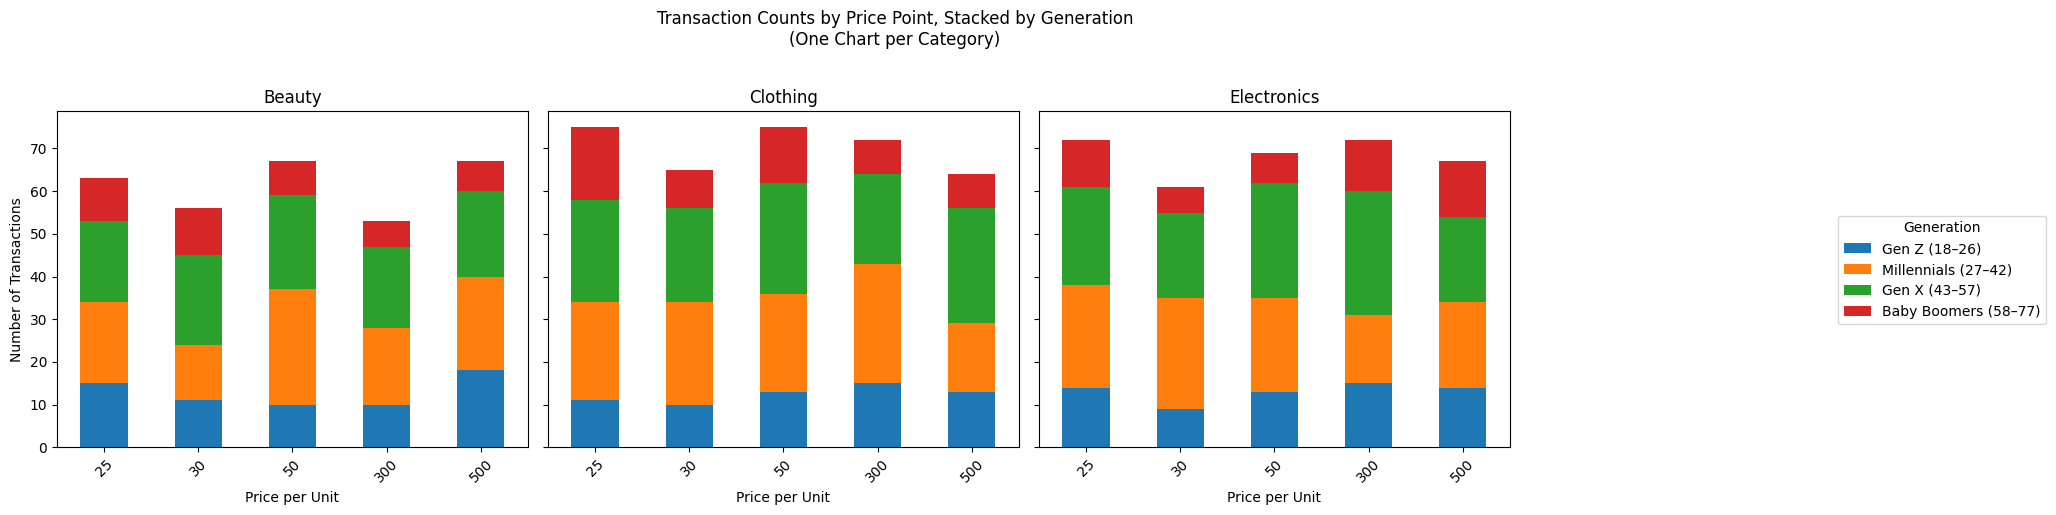

In [158]:
#Plot price trends by generation and category
# 1) Get the unique product categories
categories = retail_data['product_category'].unique()
n = len(categories)

# 2) Create one subplot per category
fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), sharey=True)

# 3) Loop through each category and plot transaction counts by price & generation
for ax, cat in zip(axes, categories):
    # Build the count pivot for this category
    count_price_gen = (
        retail_data[retail_data['product_category'] == cat]
          .groupby(['price_per_unit', 'generation'])
          .size()
          .unstack(fill_value=0)
    )
    # Plot stacked bar chart
    count_price_gen.plot(kind='bar', stacked=True, ax=ax, legend=False)
    ax.set_title(cat)
    ax.set_xlabel('Price per Unit')
    if ax is axes[0]:
        ax.set_ylabel('Number of Transactions')
    ax.tick_params(axis='x', rotation=45)

# 4) Shared legend on the right
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, title='Generation',
           bbox_to_anchor=(1.02, 0.5), loc='center left')

fig.suptitle('Transaction Counts by Price Point, Stacked by Generation\n(One Chart per Category)', y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/1087331202.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['price_per_unit', 'gender'])
/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/1087331202.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['price_per_unit', 'gender'])
/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/1087331202.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fu

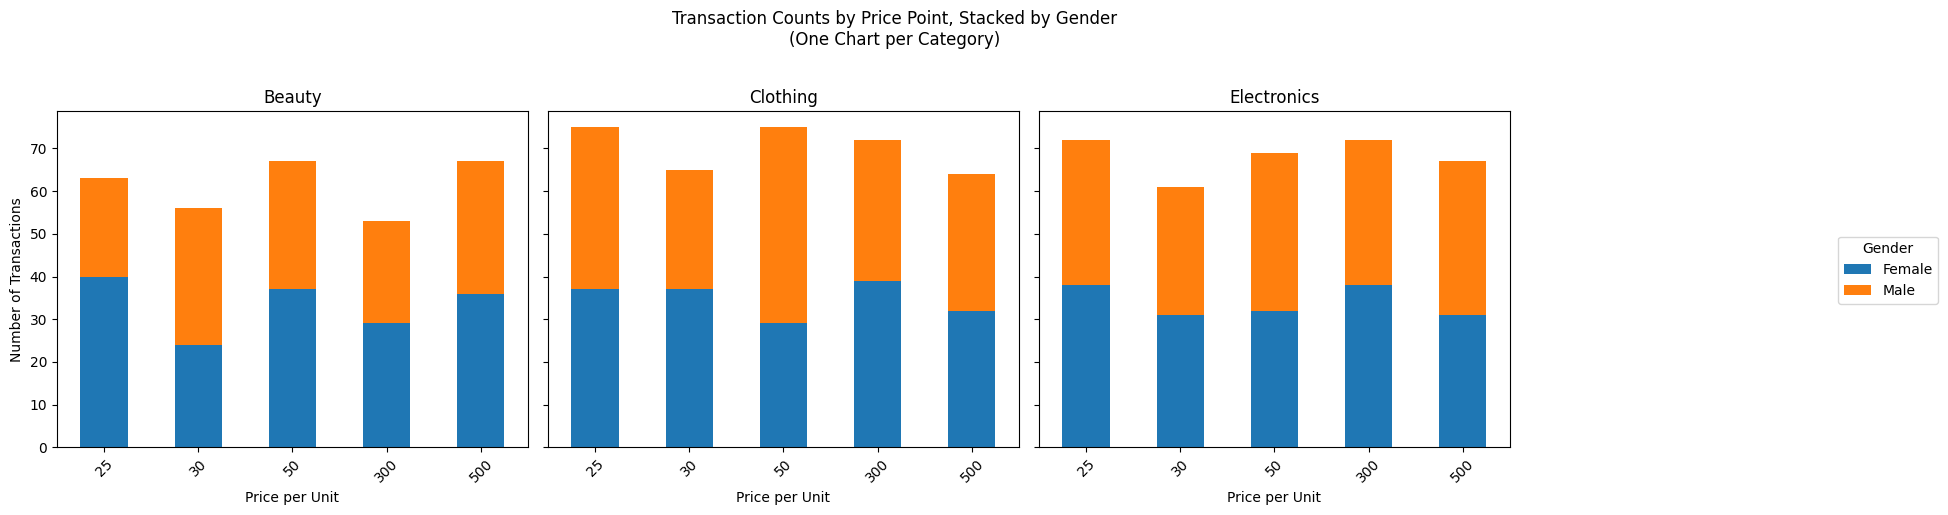

In [159]:
# Plot price points by gender and category
# 1) Get unique product categories
categories = retail_data['product_category'].unique()
n = len(categories)

# 2) Create one subplot per category
fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), sharey=True)

# 3) Loop through each category and plot transaction counts by price & gender
for ax, cat in zip(axes, categories):
    # Build the count pivot for this category
    count_price_gen = (
        retail_data[retail_data['product_category'] == cat]
          .groupby(['price_per_unit', 'gender'])
          .size()
          .unstack(fill_value=0)
    )
    # Plot stacked bar chart without individual legends
    count_price_gen.plot(kind='bar', stacked=True, ax=ax, legend=False)
    ax.set_title(cat)
    ax.set_xlabel('Price per Unit')
    if ax is axes[0]:
        ax.set_ylabel('Number of Transactions')
    ax.tick_params(axis='x', rotation=45)

# 4) Shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title='Gender',
    bbox_to_anchor=(1.02, 0.5),
    loc='center left'
)

# 5) Title and layout
fig.suptitle(
    'Transaction Counts by Price Point, Stacked by Gender\n(One Chart per Category)',
    y=1.02
)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [160]:
from pandas.api.types import CategoricalDtype
## Transformations

# Engineer date features
retail_data['month'] = retail_data.index.month
retail_data['day'] = retail_data.index.day
retail_data['day_of_week'] = retail_data.index.dayofweek
retail_data['is_weekend'] = retail_data['day_of_week'].isin([5, 6])  # Saturday=5, Sunday=6

# Map months to seasons
month_to_season = {
    1: 'winter',  2: 'winter',  3: 'spring',
    4: 'spring',  5: 'spring',  6: 'summer',
    7: 'summer',  8: 'summer',  9: 'fall',
    10: 'fall',   11: 'fall',   12: 'winter'
}
retail_data['season'] = retail_data.index.month.map(month_to_season)

# 4. Make Season an ordered categorical
season_cat = CategoricalDtype(['winter','spring','summer','fall'], ordered=True)
retail_data['season'] = retail_data['season'].astype(season_cat)

# 5. View table
print(retail_data.head())

            transaction_id customer_id  gender  age product_category  \
Date                                                                   
2023-11-24               1     CUST001    Male   34           Beauty   
2023-02-27               2     CUST002  Female   26         Clothing   
2023-01-13               3     CUST003    Male   50      Electronics   
2023-05-21               4     CUST004    Male   37         Clothing   
2023-05-06               5     CUST005    Male   30           Beauty   

            quantity  price_per_unit  total_amount           generation  \
Date                                                                      
2023-11-24         3              50           150  Millennials (27–42)   
2023-02-27         2             500          1000        Gen Z (18–26)   
2023-01-13         1              30            30        Gen X (43–57)   
2023-05-21         1             500           500  Millennials (27–42)   
2023-05-06         2              50         

In [161]:
# Cross‐tabulate to see alignment
alignment = pd.crosstab(retail_data['age'], retail_data['generation'], dropna=False)
print(alignment)

generation  Gen Z (18–26)  Millennials (27–42)  Gen X (43–57)  \
age                                                             
18                     21                    0              0   
19                     21                    0              0   
20                     21                    0              0   
21                     20                    0              0   
22                     27                    0              0   
23                     24                    0              0   
24                     15                    0              0   
25                     20                    0              0   
26                     22                    0              0   
27                      0                   23              0   
28                      0                   21              0   
29                      0                   16              0   
30                      0                   22              0   
31                      0

/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/24632096.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.Grouper(freq='M'),
/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/24632096.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  monthly_gen = retail_data.pivot_table(


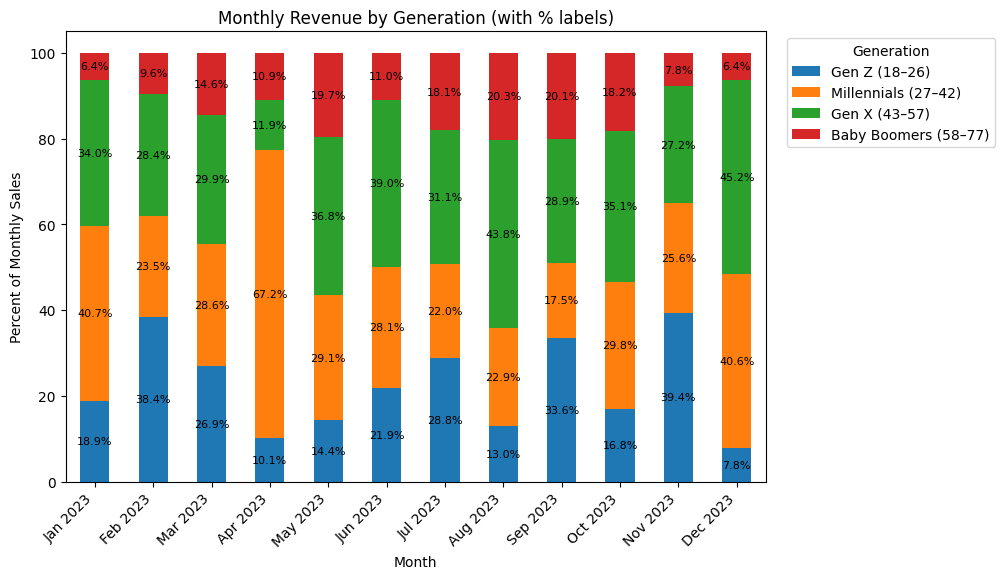

In [162]:
# Replot age group revenue by generation
# Build the pivot
monthly_gen = retail_data.pivot_table(
    index=pd.Grouper(freq='M'),
    columns='generation',
    values='total_amount',
    aggfunc='sum'
)
monthly_pct = monthly_gen.div(monthly_gen.sum(axis=1), axis=0) * 100
monthly_pct.index = monthly_pct.index.strftime('%b %Y')

# Create one figure + axes
fig, ax = plt.subplots(figsize=(12,6))

# Plot stacked bars into that axes
monthly_pct.plot(kind='bar', stacked=True, ax=ax)

# Add percent labels in-center of each bar segment
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=8)

# Move legend outside on the right
ax.legend(
    title='Generation',
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)

# Titles & labels
ax.set_title('Monthly Revenue by Generation (with % labels)')
ax.set_xlabel('Month')
ax.set_ylabel('Percent of Monthly Sales')

# Tidy layout, leave space on right for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.xticks(rotation=45, ha='right')

plt.show()

In [163]:
# Check new dtypes
dtypes = retail_data.dtypes
print(dtypes)   

transaction_id         int64
customer_id         category
gender              category
age                    int64
product_category    category
quantity               int64
price_per_unit         int64
total_amount           int64
generation          category
month                  int32
day                    int32
day_of_week            int32
is_weekend              bool
season              category
dtype: object


In [164]:
from datetime import date

# 1. Define 2023 Canadian statutory holidays
canada_holidays_2023 = {
    date(2023, 1, 1):  "New Year’s Day",
    date(2023, 2, 20): "Family Day",
    date(2023, 4, 7):  "Good Friday",
    date(2023, 5, 22): "Victoria Day",
    date(2023, 7, 1):  "Canada Day",
    date(2023, 8, 7):  "Civic Holiday",
    date(2023, 9, 4):  "Labour Day",
    date(2023, 10, 9): "Thanksgiving",
    date(2023, 12, 25):"Christmas Day",
    date(2023, 12, 26):"Boxing Day"
}

# 2. Map the index dates to holiday names
retail_data['holiday'] = (
    pd.Series(retail_data.index.date, index=retail_data.index)
      .map(canada_holidays_2023)
)
# 3. Peek at the flagged dates
holiday_retail_data = retail_data[retail_data['holiday'].notna()]
print(holiday_retail_data[['holiday']].drop_duplicates())

                   holiday
Date                      
2023-12-26      Boxing Day
2023-07-01      Canada Day
2023-01-01  New Year’s Day
2023-10-09    Thanksgiving
2023-02-20      Family Day
2023-09-04      Labour Day
2023-05-22    Victoria Day
2023-08-07   Civic Holiday
2023-12-25   Christmas Day


In [165]:
# Convert Holiday to categorical
retail_data['holiday'] = retail_data['holiday'].astype('category')

/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/2094858533.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  hol_pc = retail_data_hol.pivot_table(


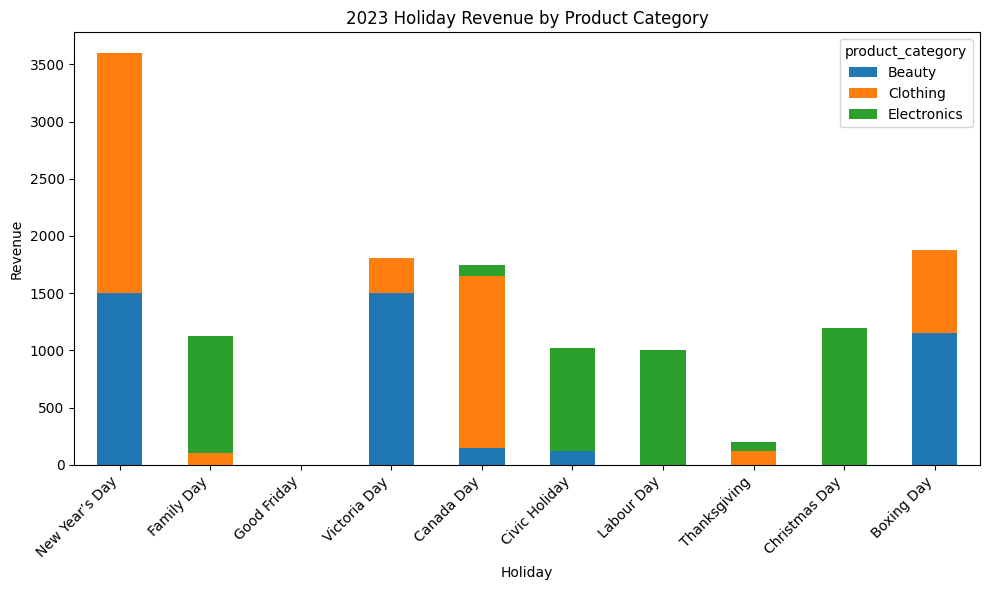

In [166]:
# Filter to holiday transactions
retail_data_hol = retail_data[retail_data['holiday'].notna()]

# Pivot: holidays × product categories
hol_pc = retail_data_hol.pivot_table(
    index='holiday',
    columns='product_category',
    values='total_amount',
    aggfunc='sum',
    fill_value=0
)

# Order holidays chronologically
holiday_order = [
    "New Year’s Day", "Family Day", "Good Friday", "Victoria Day",
    "Canada Day", "Civic Holiday", "Labour Day", "Thanksgiving",
    "Christmas Day", "Boxing Day"
]
hol_pc = hol_pc.reindex(holiday_order)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
hol_pc.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('2023 Holiday Revenue by Product Category')
ax.set_xlabel('Holiday')
ax.set_ylabel('Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/101301566.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['product_category', 'holiday', 'generation'])['total_amount']


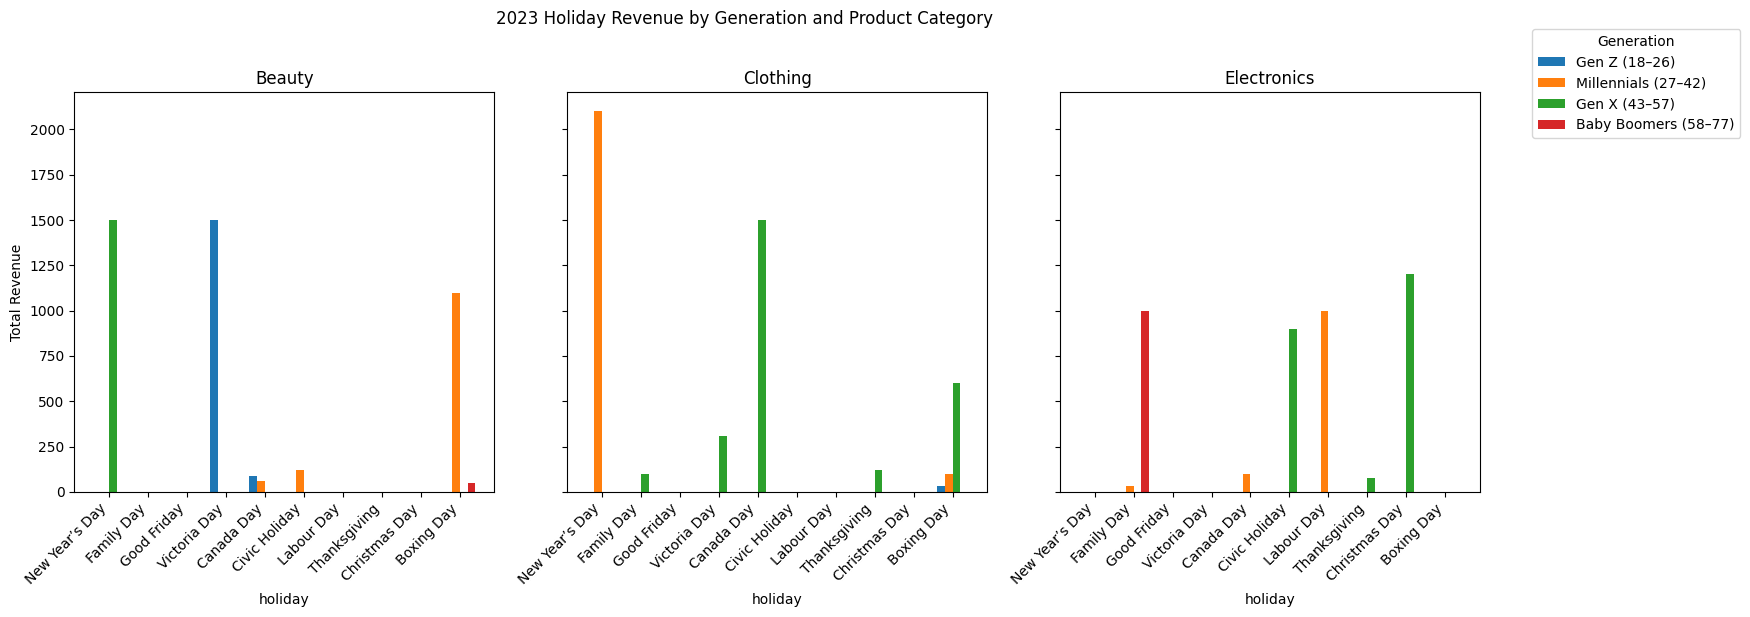

In [167]:
# Plot revenue by holiday, product category, and age group to identify trends that will drive promotional strategies

#1. Define chronological holiday order
holiday_order = [
    "New Year’s Day", "Family Day", "Good Friday", "Victoria Day",
    "Canada Day", "Civic Holiday", "Labour Day", "Thanksgiving",
    "Christmas Day", "Boxing Day"
]

# 2. Filter to holiday transactions
df_hol = retail_data[retail_data['holiday'].isin(holiday_order)]

# 3. Aggregate revenue by Product Category, Holiday, and Generation
grouped = (
    df_hol
    .groupby(['product_category', 'holiday', 'generation'])['total_amount']
    .sum()
    .reset_index()
)

# 4. Plot setup
categories  = grouped['product_category'].unique()
generations = grouped['generation'].cat.categories
x           = np.arange(len(holiday_order))
width       = 0.8 / len(generations)

fig, axes = plt.subplots(1, len(categories), figsize=(5*len(categories), 6), sharey=True)

# 5. Plot grouped bars
for ax, cat in zip(axes, categories):
    sub = grouped[grouped['product_category'] == cat]
    for i, gen in enumerate(generations):
        vals = [
            sub.loc[(sub['holiday'] == hol) & (sub['generation'] == gen), 'total_amount'].sum()
            for hol in holiday_order
        ]
        ax.bar(x + i*width, vals, width, label=gen)
    ax.set_xticks(x + width*(len(generations)-1)/2)
    ax.set_xticklabels(holiday_order, rotation=45, ha='right')
    ax.set_title(cat)
    ax.set_xlabel('holiday')

axes[0].set_ylabel('Total Revenue')

# 6. Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Generation',
           bbox_to_anchor=(1.02, 1), loc='upper left')

fig.suptitle('2023 Holiday Revenue by Generation and Product Category', y=1.02)
plt.tight_layout()
plt.show()

/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/991933867.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['season','product_category','generation'])['total_amount']


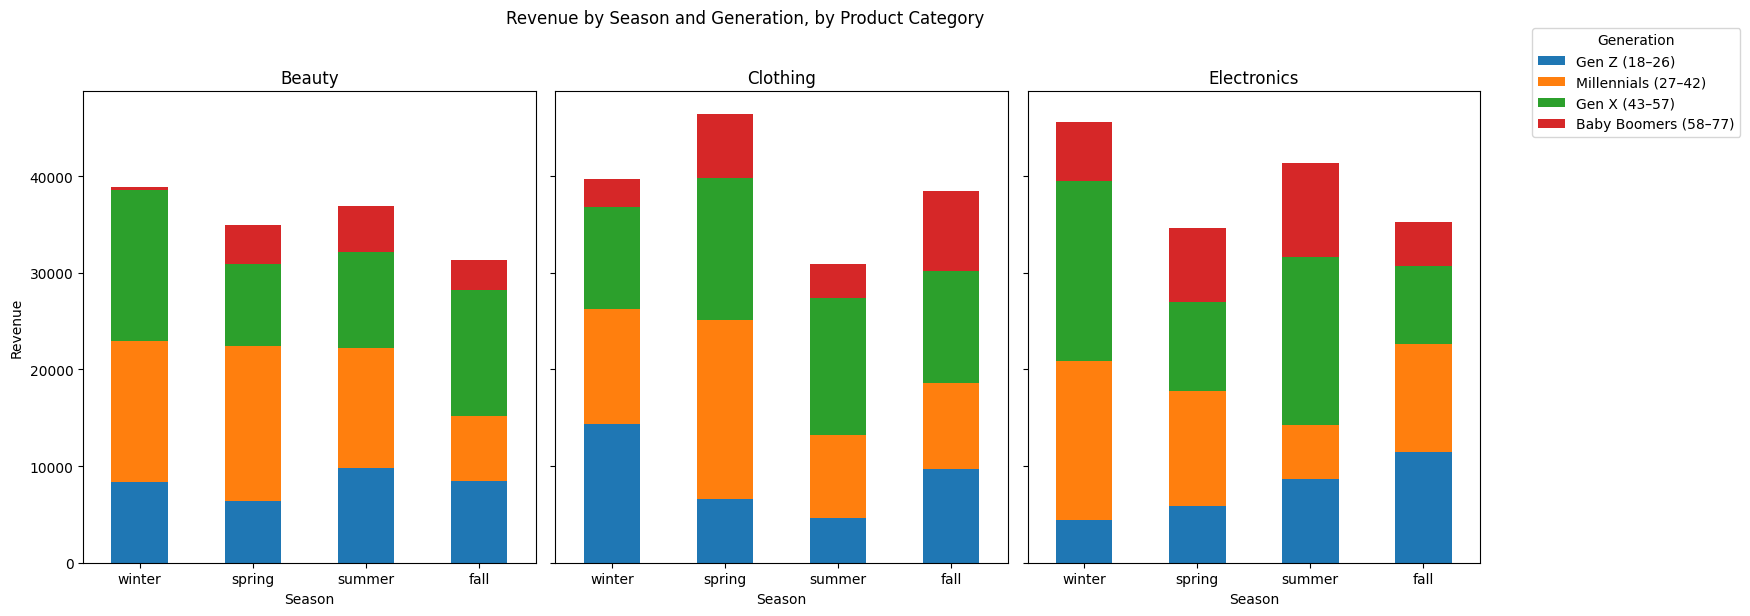

In [168]:
# Visualize revenue by season, generation, and product category
## 1. Aggregate revenue by Season, Product Category, and Generation
season_grouped = (
    retail_data
    .groupby(['season','product_category','generation'])['total_amount']
    .sum()
    .reset_index()
)

# 2. Define orders
season_order = ['winter','spring','summer','fall']
categories   = retail_data['product_category'].unique()
generations  = retail_data['generation'].cat.categories

# 3. Plot setup: one subplot per category
fig, axes = plt.subplots(1, len(categories), figsize=(5*len(categories), 6), sharey=True)

for ax, cat in zip(axes, categories):
    # 4. Pivot to get seasons × generations table
    sub = season_grouped[season_grouped['product_category']==cat]
    pivot = (
        sub
        .pivot(index='season', columns='generation', values='total_amount')
        .reindex(season_order)  # ensure correct order
        .fillna(0)
    )
    
    # 5. Plot stacked bar WITHOUT individual legend
    pivot.plot(kind='bar', stacked=True, ax=ax, legend=False)
    ax.set_title(cat)
    ax.set_xlabel('Season')
    ax.set_xticklabels(season_order, rotation=0)
    ax.set_ylabel('Revenue')

# 6. Shared legend (drawn once)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Generation',
           bbox_to_anchor=(1.02,1), loc='upper left')

plt.suptitle('Revenue by Season and Generation, by Product Category', y=1.02)
plt.tight_layout()
plt.show()

/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/2798630960.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  holiday_gen = holiday_data.pivot_table(


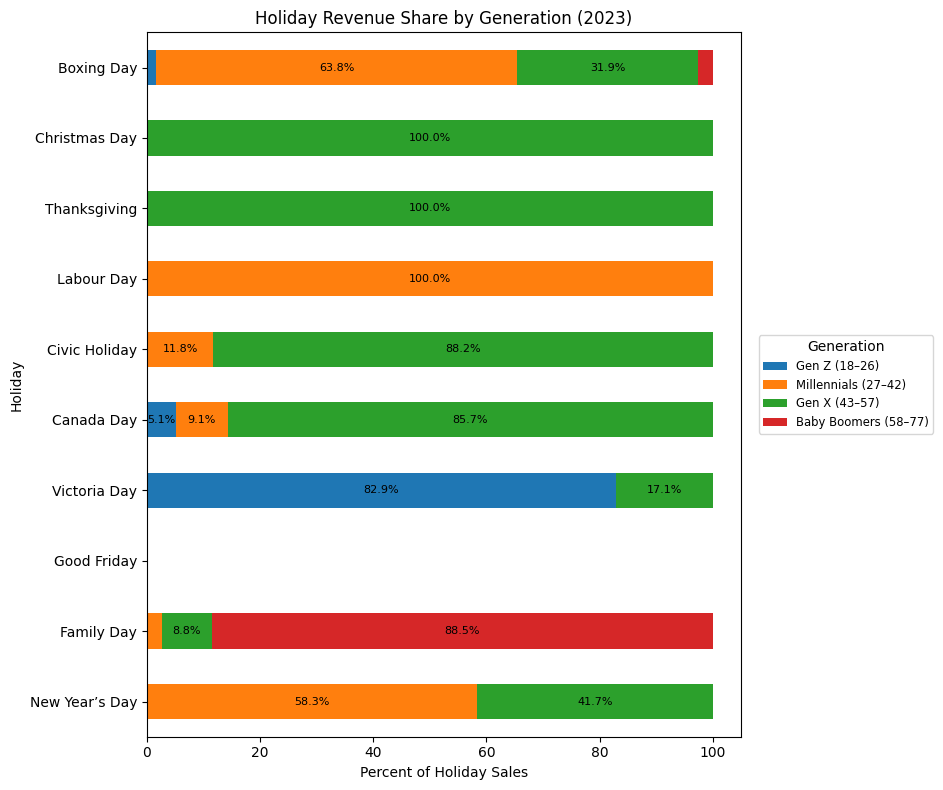

In [169]:

# Plot holiday revenue
# 1. Keep only holiday transactions
holiday_data = retail_data[retail_data['holiday'].notna()]

# 2. Pivot: total $ by Generation for each Holiday
holiday_gen = holiday_data.pivot_table(
    index='holiday',
    columns='generation',
    values='total_amount',
    aggfunc='sum'
)

# 3. Convert to percent of that holiday’s total
holiday_pct = holiday_gen.div(holiday_gen.sum(axis=1), axis=0).mul(100)

# 4. Optional: order the holidays in calendar sequence
holidays_order = [
    "New Year’s Day", "Family Day", "Good Friday", "Victoria Day",
    "Canada Day", "Civic Holiday", "Labour Day", "Thanksgiving",
    "Christmas Day", "Boxing Day"
]
holiday_pct = holiday_pct.reindex(holidays_order).iloc[::-1]

# 5. Plot
fig, ax = plt.subplots(figsize=(12,8))
holiday_pct.plot(kind='barh', stacked=True, ax=ax)
ax.invert_yaxis()

# 6. Add % labels in-bar
# Only label segments > 3%
for container in ax.containers:
    widths = [bar.get_width() for bar in container]
    labels = [f'{w:.1f}%' if w > 3 else '' for w in widths]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=8)

# Legend outside, centered vertically
ax.legend(
    title='Generation',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize='small'
)

# Labels & title
ax.set_xlabel('Percent of Holiday Sales')
ax.set_ylabel('Holiday')
ax.set_title('Holiday Revenue Share by Generation (2023)')

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()

In [170]:
price_counts = (
    retail_data
      .groupby(['product_category', 'price_per_unit'])
      .size()                              # count rows per group
      .reset_index(name='count')          # turn it into a DataFrame
      .sort_values(['product_category', 'count'], ascending=[True, False])
)

print(price_counts.head(20))

   product_category  price_per_unit  count
2            Beauty              50     67
4            Beauty             500     67
0            Beauty              25     63
1            Beauty              30     56
3            Beauty             300     53
5          Clothing              25     75
7          Clothing              50     75
8          Clothing             300     72
6          Clothing              30     65
9          Clothing             500     64
10      Electronics              25     72
13      Electronics             300     72
12      Electronics              50     69
14      Electronics             500     67
11      Electronics              30     61


/var/folders/rz/619jz5w17bv0qyf6x2ktyv340000gn/T/ipykernel_78030/12289989.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['product_category', 'price_per_unit'])


In [171]:
retail_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 998 entries, 2023-11-24 to 2023-04-12
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   transaction_id    998 non-null    int64   
 1   customer_id       998 non-null    category
 2   gender            998 non-null    category
 3   age               998 non-null    int64   
 4   product_category  998 non-null    category
 5   quantity          998 non-null    int64   
 6   price_per_unit    998 non-null    int64   
 7   total_amount      998 non-null    int64   
 8   generation        998 non-null    category
 9   month             998 non-null    int32   
 10  day               998 non-null    int32   
 11  day_of_week       998 non-null    int32   
 12  is_weekend        998 non-null    bool    
 13  season            998 non-null    category
 14  holiday           27 non-null     category
dtypes: bool(1), category(6), int32(3), int64(5)
memory usag

In [172]:
# Encode gender: Assume 'Male' = 1, 'Female' = 0
retail_data['gender_enc'] = retail_data['gender'].map({'Female': 0, 'Male': 1})

# Encode is_weekend: Already boolean — convert to int (True = 1, False = 0)
retail_data['is_weekend_enc'] = retail_data['is_weekend'].astype(int)

# ✅ Preview
print(retail_data[['gender', 'gender_enc', 'is_weekend', 'is_weekend_enc']].head())

            gender gender_enc  is_weekend  is_weekend_enc
Date                                                     
2023-11-24    Male          1       False               0
2023-02-27  Female          0       False               0
2023-01-13    Male          1       False               0
2023-05-21    Male          1        True               1
2023-05-06    Male          1        True               1


In [173]:
retail_data['gender_enc'] = retail_data['gender'].map({'Female': 0, 'Male': 1}).astype(int)
retail_data['is_weekend_enc'] = retail_data['is_weekend'].astype(int)

In [174]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 998 entries, 2023-11-24 to 2023-04-12
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   transaction_id    998 non-null    int64   
 1   customer_id       998 non-null    category
 2   gender            998 non-null    category
 3   age               998 non-null    int64   
 4   product_category  998 non-null    category
 5   quantity          998 non-null    int64   
 6   price_per_unit    998 non-null    int64   
 7   total_amount      998 non-null    int64   
 8   generation        998 non-null    category
 9   month             998 non-null    int32   
 10  day               998 non-null    int32   
 11  day_of_week       998 non-null    int32   
 12  is_weekend        998 non-null    bool    
 13  season            998 non-null    category
 14  holiday           27 non-null     category
 15  gender_enc        998 non-null    int64   
 16  is_week

In [175]:
# Check for numeric columns that need normalization

import pandas as pd
import numpy as np

# 1. Select numeric columns
numeric_cols = ['quantity', 'price_per_unit']
numeric_data = retail_data[numeric_cols]

# 2. Compute summary stats
stats = numeric_data.agg(['min', 'max', 'mean', 'std']).T
stats['range'] = stats['max'] - stats['min']
stats['ratio'] = stats['max'] / stats['min'].replace(0, np.nan)
stats['skew'] = numeric_data.skew()

# 3. Print the stats table
print("Summary stats for numeric columns:\n")
print(stats.round(2))

# 4. Flag columns that likely need normalization or transformation
to_normalize = stats[
    (stats['ratio'] > 100) |
    (stats['std'] > stats['mean']) |
    (stats['skew'].abs() > 1)
].index.tolist()

print("\nFeatures to consider normalizing or transforming:")
print(to_normalize)

Summary stats for numeric columns:

                 min    max    mean     std  range  ratio  skew
quantity         1.0    4.0    2.52    1.13    3.0    4.0 -0.01
price_per_unit  25.0  500.0  179.72  189.54  475.0   20.0  0.74

Features to consider normalizing or transforming:
['price_per_unit']


In [176]:
# Check if dependent variable  needs to be normalized
total_amount = retail_data['total_amount']

# 1. Compute basic statistics
ta_min   = total_amount.min()
ta_max   = total_amount.max()
ta_mean  = total_amount.mean()
ta_std   = total_amount.std()
ta_range = ta_max - ta_min
ta_ratio = ta_max / ta_min if ta_min != 0 else np.nan
ta_skew  = total_amount.skew()

# 2. Create summary table
stats_total_amount = pd.Series({
    'min':    ta_min,
    'max':    ta_max,
    'mean':   ta_mean,
    'std':    ta_std,
    'range':  ta_range,
    'ratio':  ta_ratio,
    'skew':   ta_skew
})

# 3. Display summary
print("📊 Summary stats for `total_amount`:\n")
print(stats_total_amount.round(2))

# 4. Check if normalization or transformation is needed
flags = []

if stats_total_amount['ratio'] > 100:
    flags.append("very wide scale (max/min > 100)")
if stats_total_amount['std'] > stats_total_amount['mean']:
    flags.append("std > mean (high variance)")
if abs(stats_total_amount['skew']) > 1:
    flags.append("|skew| > 1 (highly skewed)")

# 5. Recommendation
if flags:
    print("\n`total_amount` may benefit from normalization or log transformation because:")
    for reason in flags:
        print(f" - {reason}")
else:
    print("\n`total_amount` appears reasonably scaled and symmetric; transformation may not be needed.")

📊 Summary stats for `total_amount`:

min        25.00
max      2000.00
mean      455.38
std       559.42
range    1975.00
ratio      80.00
skew        1.38
dtype: float64

`total_amount` may benefit from normalization or log transformation because:
 - std > mean (high variance)
 - |skew| > 1 (highly skewed)


          feature        VIF
0           const  29.497480
1  is_weekend_enc   2.724433
2     day_of_week   2.710723
3  transaction_id   1.010376
4             day   1.010085
5             age   1.009139
6  price_per_unit   1.008810
7      gender_enc   1.008527
8        quantity   1.005331
9           month   1.005300


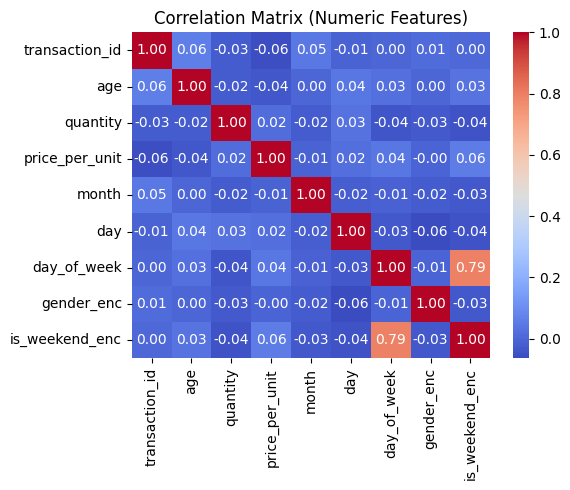

In [177]:

# Calculate multicolinearity using Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Select only numerical features
numeric_feats = (
    retail_data
    .select_dtypes(include=[np.number])
    .columns
    .drop('total_amount')
)

# 2. Subset and add constant
X_num = retail_data[numeric_feats]
X_const = sm.add_constant(X_num)

# 3. Compute VIF for each feature (including the constant, which you can ignore later)
vif_df = pd.DataFrame({
    'feature': X_const.columns,
    'VIF': [
        variance_inflation_factor(X_const.values, i)
        for i in range(X_const.shape[1])
    ]
})

# 4. Display VIF sorted descending
print(vif_df.sort_values('VIF', ascending=False).reset_index(drop=True))

# 5. Plot a correlation heatmap of the numeric features
plt.figure(figsize=(6, 5))
corr = X_num.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()

In [178]:
retail_data.describe()

,transaction_id,age,quantity,price_per_unit,total_amount,month,day,day_of_week,gender_enc,is_weekend_enc
count,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000
mean,500.640281,41.377756,2.515030,179.719439,455.380762,6.560120,15.338677,2.963928,0.488978,0.288577
std,288.924735,13.688342,1.132751,189.541154,559.420064,3.447252,8.857363,2.018645,0.500129,0.453328
min,1.000000,18.000000,1.000000,25.000000,25.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,251.250000,29.000000,1.000000,30.000000,60.000000,4.000000,7.000000,1.000000,0.000000,0.000000
50%,500.500000,42.000000,3.000000,50.000000,135.000000,6.000000,15.000000,3.000000,0.000000,0.000000
75%,750.750000,53.000000,4.000000,300.000000,900.000000,10.000000,23.000000,5.000000,1.000000,1.000000
max,1000.000000,64.000000,4.000000,500.000000,2000.000000,12.000000,31.000000,6.000000,1.000000,1.000000


In [179]:
retail_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 998 entries, 2023-11-24 to 2023-04-12
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   transaction_id    998 non-null    int64   
 1   customer_id       998 non-null    category
 2   gender            998 non-null    category
 3   age               998 non-null    int64   
 4   product_category  998 non-null    category
 5   quantity          998 non-null    int64   
 6   price_per_unit    998 non-null    int64   
 7   total_amount      998 non-null    int64   
 8   generation        998 non-null    category
 9   month             998 non-null    int32   
 10  day               998 non-null    int32   
 11  day_of_week       998 non-null    int32   
 12  is_weekend        998 non-null    bool    
 13  season            998 non-null    category
 14  holiday           27 non-null     category
 15  gender_enc        998 non-null    int64   
 16  is_week

In [180]:
# Drop attributes
X = retail_data.drop(columns=['transaction_id','customer_id','age','gender','month','day','day_of_week','total_amount', 'price_per_unit'])
y = retail_data['total_amount']

# Identify categorical features
categorical_features = [
    'product_category',
    'generation',
    'holiday',
    'season'
]

# Identify numerical features
numerical_features = [col for col in X.columns if col not in categorical_features and col != 'total_amount']

# Quick sanity-check
print("Categorical:", categorical_features)
print("Numerical:  ", numerical_features)

Categorical: ['product_category', 'generation', 'holiday', 'season']
Numerical:   ['quantity', 'is_weekend', 'gender_enc', 'is_weekend_enc']


In [181]:
X.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 998 entries, 2023-11-24 to 2023-04-12
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   product_category  998 non-null    category
 1   quantity          998 non-null    int64   
 2   generation        998 non-null    category
 3   is_weekend        998 non-null    bool    
 4   season            998 non-null    category
 5   holiday           27 non-null     category
 6   gender_enc        998 non-null    int64   
 7   is_weekend_enc    998 non-null    int64   
dtypes: bool(1), category(4), int64(3)
memory usage: 37.0 KB


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

# Recreate list of updated numerical features
numerical_features_log = X_train.drop(columns=categorical_features).columns.tolist()

# ColumnTransformer 
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features_log),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [184]:
# Transform the target variable Y using log transformation
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [185]:
#Build Model

model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(
        max_depth = 5,
        min_samples_leaf = 2,
        min_samples_split = 5,
        random_state=42))
])

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['quantity', 'is_weekend',
                                                   'gender_enc',
                                                   'is_weekend_enc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['product_category',
                                                   'generation', 'holiday',
                                                   'season'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=2,
                                       min_samples_split=5, random_state=42))])

In [186]:
#Fit on the log-transformed training data
model.fit(X_train, y_train_log)

# Predict on the log-transformed test set
y_pred_log = model.predict(X_test)

# Reverse log-transform to compare on original scale
y_pred = np.expm1(y_pred_log)

# Evaluate performance
mae= mean_absolute_error(y_test, y_pred)
rmse= np.sqrt(mean_squared_error(y_test, y_pred))

# Store the results
final_metrics_d = {
    'Model': '(DecisionTree, preproccessor)',
    'MAE': mae,
    'RMSE': rmse
}

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 409.59
RMSE: 578.27


In [187]:
print(y.describe())

count     998.000000
mean      455.380762
std       559.420064
min        25.000000
25%        60.000000
50%       135.000000
75%       900.000000
max      2000.000000
Name: total_amount, dtype: float64


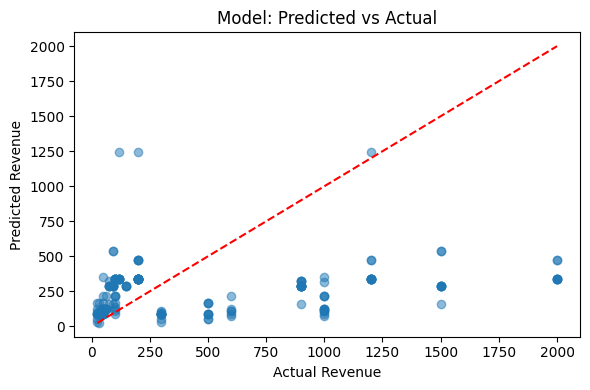

In [188]:
# Visualize the predictions vs actual values for Pipeline A
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Model: Predicted vs Actual")
plt.tight_layout()
plt.show()

In [189]:
importances = model.named_steps['model'].feature_importances_
features = model.named_steps['preprocessor'].get_feature_names_out()
pd.Series(importances, index=features).sort_values(ascending=False).head(10)

num__quantity                           0.728380
cat__generation_Baby Boomers (58–77)    0.042725
cat__season_winter                      0.036817
cat__product_category_Beauty            0.025310
cat__generation_Gen Z (18–26)           0.024696
num__gender_enc                         0.024553
cat__season_summer                      0.022232
num__is_weekend                         0.021462
cat__generation_Gen X (43–57)           0.018452
num__is_weekend_enc                     0.018089
dtype: float64

In [190]:
#Hyperparameter
# Define parameter grid for Decision Tree
param_grid= {
    'model__max_depth': [3, 5, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid= GridSearchCV(
    model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid.fit(X_train, y_train_log)

# Evaluate and display test results
best_model = grid.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Recalculate and print test metrics
mae= mean_absolute_error(y_test, y_pred)
rmse= np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MAE (Best Decision Tree): {mae:.2f}")
print(f"Test RMSE (Best Decision Tree): {rmse:.2f}")
print("Best params:",grid.best_params_)

Test MAE (Best Decision Tree): 407.36
Test RMSE (Best Decision Tree): 574.46
Best params: {'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}


In [191]:
# Cross Validation and Evaluation
scores = cross_validate(model, X_train, y_train,
                        scoring=['neg_mean_squared_error', 'r2'],
                        cv=5, return_train_score=True)

print("CV Results:", pd.DataFrame(scores))

CV Results:    fit_time  score_time  test_neg_mean_squared_error  \
0  0.005923    0.001813               -259802.378768   
1  0.003433    0.002514               -347775.438416   
2  0.002868    0.001744               -362951.764757   
3  0.003213    0.001885               -285455.573397   
4  0.002728    0.001560               -281324.563120   

   train_neg_mean_squared_error   test_r2  train_r2  
0                -247265.437668 -0.077215  0.263207  
1                -233541.728019 -0.035218  0.252866  
2                -225456.809272 -0.028670  0.269491  
3                -241105.919291  0.100278  0.240811  
4                -244977.134685  0.158901  0.218004  


In [192]:
print(set(X_train.columns) & {'total_amount'})
print(X_train.equals(X_test))  # should be False

set()
False


In [193]:
print("Average total_amount:", y_test.mean())
print("MAE as % of avg:", 100 * mean_absolute_error(y_test, y_pred) / y_test.mean())

Average total_amount: 483.05
MAE as % of avg: 84.330751105673
